In [1]:
import sys
import hashlib
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

def load_txt(fn):
    d = pd.read_csv(fn, sep="\t", header=None)
    d.columns = ["CHROM", "POS", "NeighId", "SVLEN", "SVTYPE",
                 "TRFcopies", "TRFDiff", "TRFrepeat", "ALT"]
    def mk_key(line):
        result = hashlib.md5(f"{line['CHROM']} {line['POS']} {line['ALT']} {line['SVTYPE']}".encode())
        return result.hexdigest()

    d = d[(d["SVTYPE"] == 'INS') & (d["TRFDiff"] != ".")]
    d["var key"] = d.apply(mk_key, axis=1)
    d["TRFDiff"] = d["TRFDiff"].astype(float)
    d.set_index("var key", inplace=True)
    return d

def make_summary(base, other):
    cmp = base.join(other, rsuffix='cmp')
    parts = []
    for pos, i in enumerate(cmp.groupby(["NeighId", "TRFrepeat"])):
        base = i[1]["TRFDiff"].value_counts()
        other = i[1]["TRFDiffcmp"].value_counts(dropna=False)
        view = pd.concat([base, other], axis=1)
        view.reset_index(inplace=True)
        view.columns = ["copynum", "exactcnt", "othercnt"]
        view["loc key"] = pos
        parts.append(view)
    data = pd.concat(parts)
    rows = []
    for key, ck in data.groupby("loc key"):
        rows.append([key, 
                     (~ck["exactcnt"].isna()).sum(),
                     (ck["exactcnt"] > 1).sum(),
                     len(ck[(ck["othercnt"] > 1) & (~ck["exactcnt"].isna())]),
                     (ck["othercnt"].isna()).sum()])
    sum_dat = pd.DataFrame(rows, columns=["loc key", 
                                          "exact_cn_cnt",
                                          "exact_redund_vars",
                                          "other_redund_vars",
                                          "other_missing_cnt"]
                          )
    return sum_dat

In [3]:
exa = load_txt("../temp/trf_data/exact.txt.gz")
tru = load_txt("../temp/trf_data/truvari.txt.gz")
jas = load_txt("../temp/trf_data/jasmine.txt.gz")
sur = load_txt("../temp/trf_data/survivor.txt.gz")
nav = load_txt("../temp/trf_data/naive.txt.gz")

In [4]:
tru_sum = make_summary(exa, tru)
jas_sum = make_summary(exa, jas)
sur_sum = make_summary(exa, sur)
nav_sum = make_summary(exa, nav)

In [5]:
tru_sum.head()

,loc key,exact_cn_cnt,exact_redund_vars,other_redund_vars,other_missing_cnt
0,0,5,2,0,1
1,1,2,0,0,0
2,2,7,0,0,2
3,3,2,2,0,0
4,4,10,3,1,0


In [6]:
print("Total TR Loci", len(tru_sum["exact_redund_vars"]))
non_redund = tru_sum[tru_sum["exact_redund_vars"] == 0]
print("Non-Redundant Sites:", len(non_redund))
print("Non-Redundant Num Variants:", non_redund["exact_cn_cnt"].sum())

has_redund = tru_sum[tru_sum["exact_redund_vars"] != 0]
print("Redund Sites:", len(has_redund))
print("Redund Num Variants:", has_redund[["exact_redund_vars", "exact_cn_cnt"]].sum().sum())

Total TR Loci 20207
Non-Redundant Sites: 11151
Non-Redundant Num Variants: 20071
Redund Sites: 9056
Redund Num Variants: 91500


In [7]:
redund_data = []
for name, i in [("tru", tru_sum), ("jas", jas_sum), ("sur", sur_sum), ("nav", nav_sum)]:
    p = i[i["exact_redund_vars"] != 0][["other_redund_vars"]]
    p["name"] = name
    redund_data.append(p)
redund_data = pd.concat(redund_data).reset_index()

missing_data = []
for name, i in [("tru", tru_sum), ("jas", jas_sum), ("sur", sur_sum), ("nav", nav_sum)]:
    p = i[i["exact_redund_vars"] != 0][["other_missing_cnt"]]
    p["name"] = name
    missing_data.append(p)
missing_data = pd.concat(missing_data).reset_index()

In [8]:
redund_data["redund_bins"] = pd.cut(redund_data["other_redund_vars"], [0, 1, 100], 
                               labels=["None", "Any"], right=False)

In [9]:
redund_data['name'] = redund_data["name"].map({'tru':"Truvari",
                           'nav': "Naive",
                           'jas': "Jasmine",
                           'sur': "SURVIVOR"})

In [10]:
redund_data.columns = ['index', 'other_redund_vars', 'Merge', 'redund_bins']

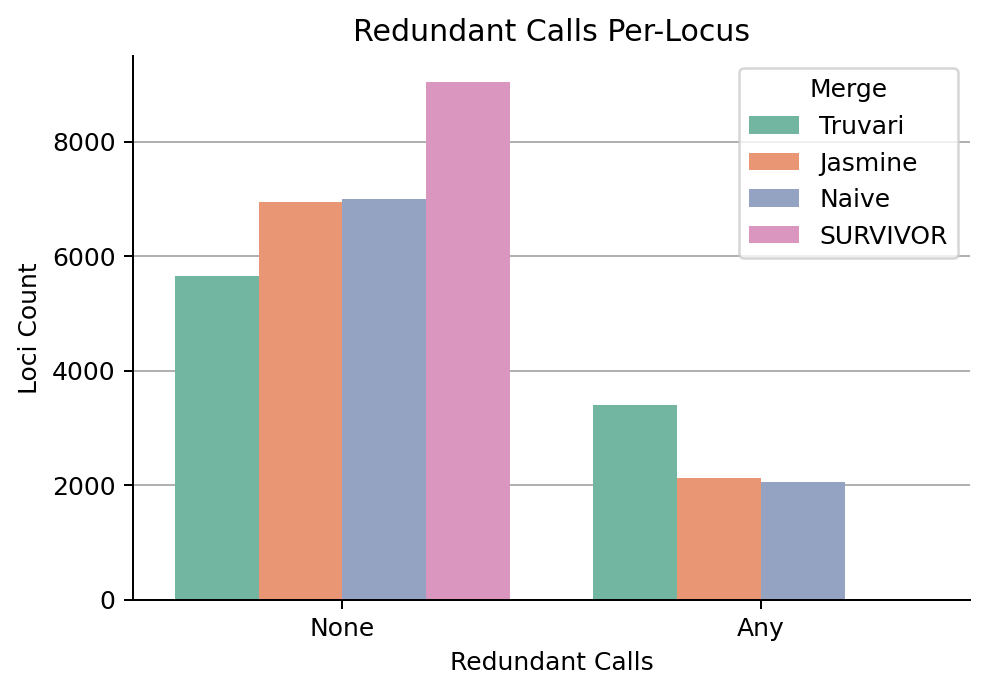

In [11]:
plt.figure(dpi=180)
#Dark2
with sb.color_palette("Set2", 4):
    p = sb.countplot(data=redund_data, 
                     x="redund_bins", 
                     hue="Merge", 
                    hue_order=["Truvari", "Jasmine", "Naive", "SURVIVOR"])#, multiple='stack')
    sb.despine()
    plt.grid(which='major', axis='y')
    p.set_axisbelow(True)
    hide = p.set(xlabel="Redundant Calls",
                 title="Redundant Calls Per-Locus",
                 ylabel="Loci Count")

In [12]:
missing_data['name'] = missing_data["name"].map({'tru':"Truvari",
                           'nav': "Naive",
                           'jas': "Jasmine",
                           'sur': "SURVIVOR"})
missing_data.groupby(["name"])["other_missing_cnt"].describe(percentiles=[0.5, 0.99]).sort_values('mean')

,count,mean,std,min,50%,99%,max
name,,,,,,,
Truvari,9056.0,1.885159,3.702441,0.0,0.0,19.00,55.0
Jasmine,9056.0,4.430543,6.607730,0.0,2.0,31.00,108.0
Naive,9056.0,5.482774,7.927469,0.0,3.0,37.00,118.0
SURVIVOR,9057.0,7.123772,8.215060,0.0,4.0,39.44,120.0


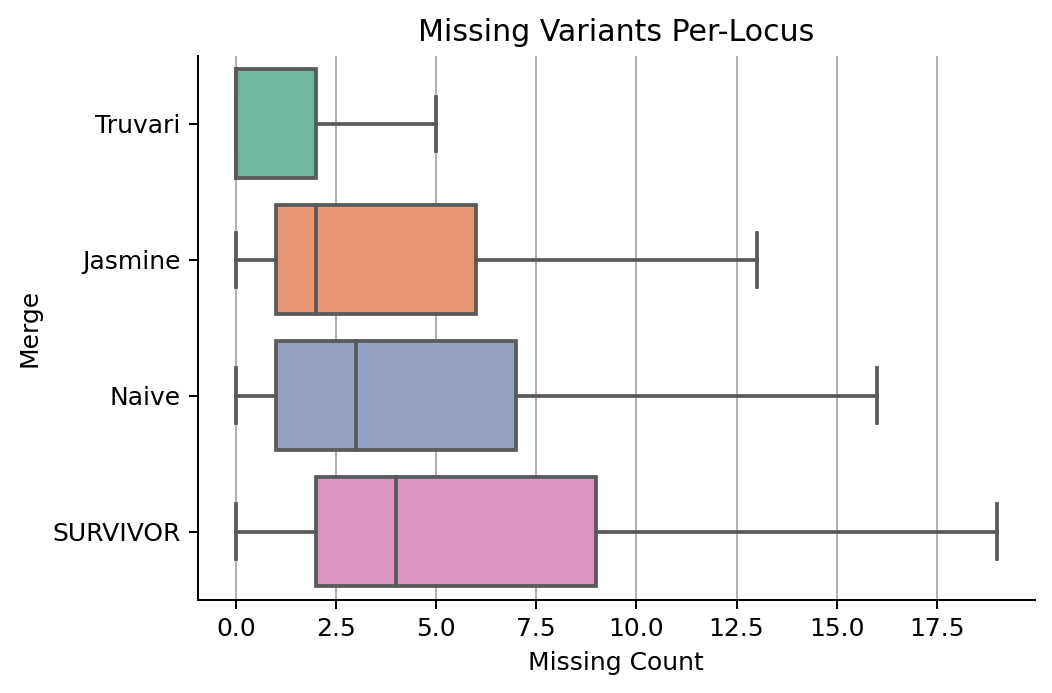

In [13]:
plt.figure(dpi=180)
# Dark2
with sb.color_palette("Set2", 4):
    p = sb.boxplot(data=missing_data, 
                   x="other_missing_cnt", 
                   y="name", 
                   showfliers=False, 
                   order=["Truvari", "Jasmine", "Naive", "SURVIVOR"])
    sb.despine()
    plt.grid(which='major', axis='x')
    p.set_axisbelow(True)
    hide = p.set(title="Missing Variants Per-Locus", ylabel="Merge", xlabel="Missing Count")

In [28]:
for i in missing_data['name'].unique():
    v = missing_data[missing_data['name'] == i]
    t = v['other_missing_cnt'].value_counts()[0] 
    print (i, "%.1f" % (t / len(v) * 100))

Truvari 52.6
Jasmine 23.5
SURVIVOR 0.8
Naive 20.4


In [24]:
redund_data.groupby(['Merge', 'redund_bins']).size().unstack()

redund_bins,None,Any
Merge,,
Jasmine,6938,2118
Naive,6998,2058
SURVIVOR,9044,13
Truvari,5658,3398


In [19]:
import ptitprince as pt
import matplotlib.pyplot as plt

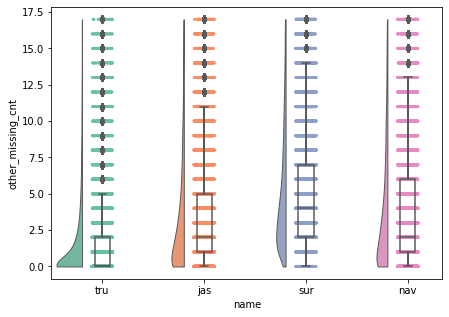

In [20]:
# Changing orientation
dx="name"; dy="other_missing_cnt"; ort="v"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(7, 5))
df = missing_data[missing_data["other_missing_cnt"] < 18]
ax=pt.RainCloud(x = dx, y = dy, data = df, palette = pal, bw = sigma,
                 width_viol = .5, ax = ax, orient = ort)
